<a href="https://colab.research.google.com/github/apptempoit/VIT_Transformer/blob/main/VIT_Publish_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q transformers torch torchvision matplotlib numpy seaborn opencv-python timm pandas



Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Saving radar-cropped-03-04-25-20-00-40.png to radar-cropped-03-04-25-20-00-40 (3).png
Saving radar-cropped-03-04-25-19-45-39.png to radar-cropped-03-04-25-19-45-39 (2).png
Saving radar-cropped-03-04-25-19-30-39.png to radar-cropped-03-04-25-19-30-39 (2).png
Saving radar-cropped-03-04-25-19-15-38.png to radar-cropped-03-04-25-19-15-38 (2).png


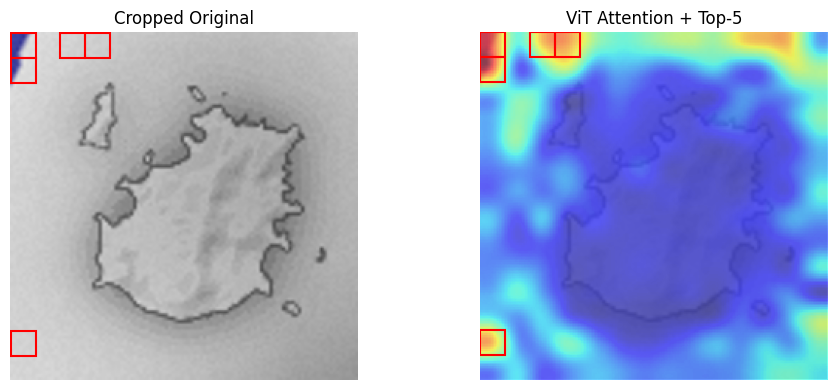

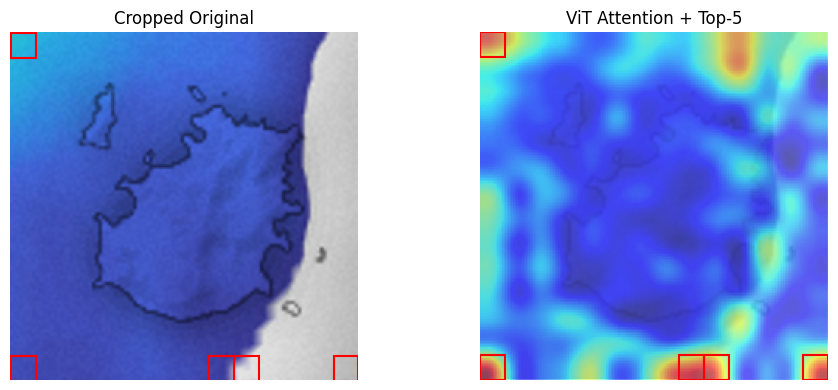

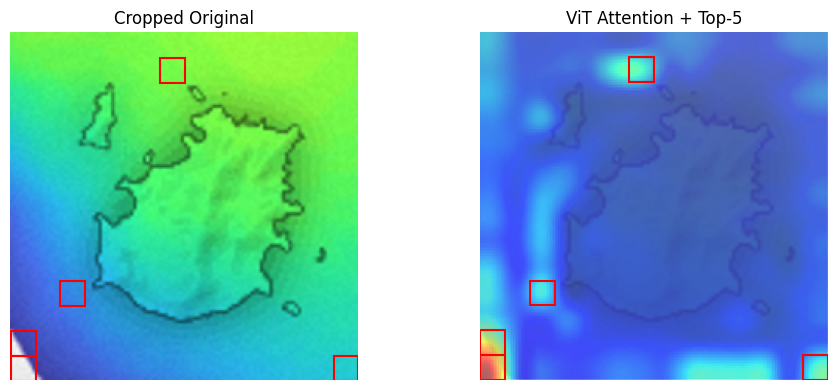

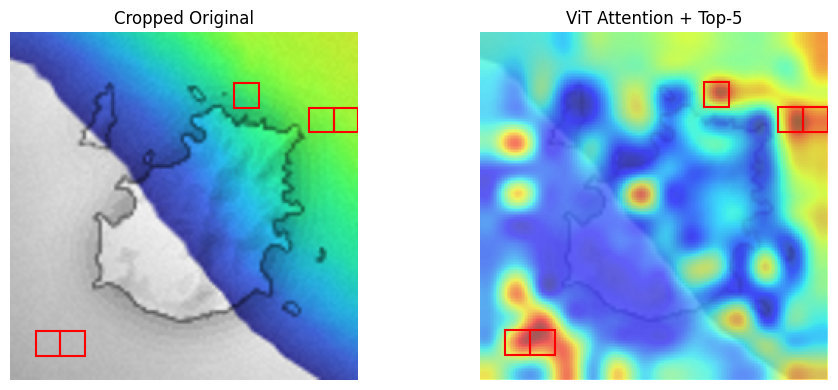

,file,mean_R,mean_G,mean_B,mean_gray,cloud_scale,edge_strength,xtop1,ytop1,xtop2,ytop2,xtop3,ytop3,xtop4,ytop4,xtop5,ytop5
0,radar-cropped-03-04-25-20-00-40 (3).png,129.87,131.39,183.86,136.98,0.537,90.59,0,0,0,16,48,0,0,192,32,0
1,radar-cropped-03-04-25-19-45-39 (2).png,74.40,76.14,165.51,85.79,0.336,42.21,128,208,0,208,144,208,208,208,0,0
2,radar-cropped-03-04-25-19-30-39 (2).png,210.43,210.60,225.17,212.23,0.832,72.22,0,208,0,192,208,208,32,160,96,16
3,radar-cropped-03-04-25-19-15-38 (2).png,65.71,225.95,103.38,164.04,0.643,18.02,144,32,192,48,32,192,16,192,208,48


In [ ]:

!pip install -q transformers torch torchvision matplotlib numpy seaborn opencv-python timm pandas
model_name = "google/vit-base-patch16-224"
fe  = ViTFeatureExtractor.from_pretrained(model_name)
vit = ViTForImageClassification.from_pretrained(model_name,
                                                output_attentions=True).eval()

uploaded = files.upload()
if not uploaded:
    raise ValueError("No files uploaded!")

rows = []
patch_size = 16


for fname in uploaded.keys():


    full_image = Image.open(fname).convert("RGB")
    cropped = full_image.crop((70, 120, 70 + 110, 120 + 110))
    img_pil = cropped.resize((224, 224))
    img_np  = np.array(img_pil)
    gray_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    inputs = fe(images=img_pil, return_tensors="pt")
    with torch.no_grad():
        out = vit(**inputs)
    attn_last = out.attentions[-1].squeeze(0).mean(0).cpu().numpy()  # (197,197)

    cls2patch = attn_last[0, 1:]
    heat14    = cls2patch.reshape(14, 14)
    heat224   = cv2.resize(heat14, (224, 224), interpolation=cv2.INTER_CUBIC)

    top5_idx = np.argsort(cls2patch)[-5:][::-1]
    top5_rc  = [divmod(int(i), 14) for i in top5_idx]
    top5_xy  = [(c * patch_size, r * patch_size) for r, c in top5_rc]

    xtop1, ytop1 = top5_xy[0]
    roi_rgb  = img_np[ytop1:ytop1+patch_size, xtop1:xtop1+patch_size]
    roi_gray = gray_np[ytop1:ytop1+patch_size, xtop1:xtop1+patch_size]

    mean_rgb   = roi_rgb.mean((0,1))
    mean_gray  = roi_gray.mean()
    cloud_scale = mean_gray / 255.0
    sobx = cv2.Sobel(roi_gray, cv2.CV_64F, 1, 0, ksize=3)
    soby = cv2.Sobel(roi_gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_strength = np.mean(np.hypot(sobx, soby))

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(img_np); ax[0].axis("off"); ax[0].set_title("Cropped Original")

    for x, y in top5_xy:
        ax[0].add_patch(patches.Rectangle((x, y), patch_size, patch_size,
                                          edgecolor='red', facecolor='none', linewidth=1.5))

    ax[1].imshow(img_np, alpha=0.5)
    sns.heatmap(heat224, cmap="jet", alpha=.6, ax=ax[1], cbar=False)
    for x, y in top5_xy:
        ax[1].add_patch(patches.Rectangle((x, y), patch_size, patch_size,
                                          edgecolor='red', facecolor='none', linewidth=1.5))
    ax[1].axis("off"); ax[1].set_title("ViT Attention + Top-5")
    plt.tight_layout(); plt.show()

    # 4-g) store info
    row = {
        "file": fname,
        "mean_R": round(mean_rgb[0],2),
        "mean_G": round(mean_rgb[1],2),
        "mean_B": round(mean_rgb[2],2),
        "mean_gray": round(mean_gray,2),
        "cloud_scale": round(cloud_scale,3),
        "edge_strength": round(edge_strength,2),
    }
    for i, (x, y) in enumerate(top5_xy):
        row[f"xtop{i+1}"] = x
        row[f"ytop{i+1}"] = y
    rows.append(row)

df = pd.DataFrame(rows)
display(df)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Saving radar-cropped-03-04-25-20-00-40.png to radar-cropped-03-04-25-20-00-40 (11).png
Saving sat-cropped-03-04-25-20-00-09.png to sat-cropped-03-04-25-20-00-09 (5).png
Saving radar-cropped-03-04-25-19-45-39.png to radar-cropped-03-04-25-19-45-39 (10).png
Saving sat-cropped-03-04-25-19-45-08.png to sat-cropped-03-04-25-19-45-08 (5).png
Saving radar-cropped-03-04-25-19-30-39.png to radar-cropped-03-04-25-19-30-39 (10).png
Saving sat-cropped-03-04-25-19-30-08.png to sat-cropped-03-04-25-19-30-08 (5).png
Saving radar-cropped-03-04-25-19-15-38.png to radar-cropped-03-04-25-19-15-38 (10).png
Saving sat-cropped-03-04-25-19-15-09.png to sat-cropped-03-04-25-19-15-09 (5).png


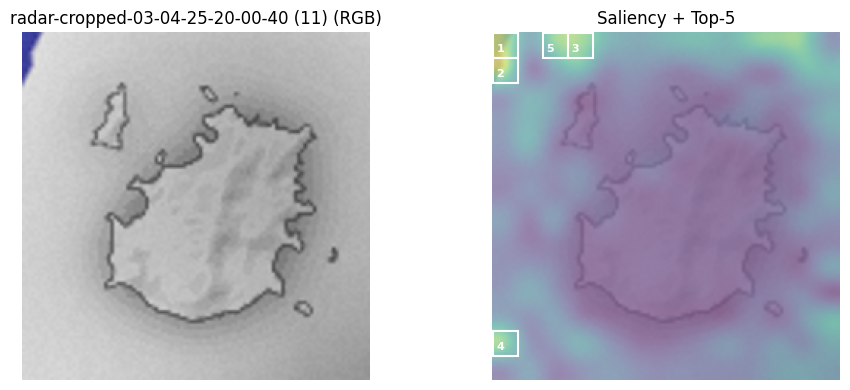

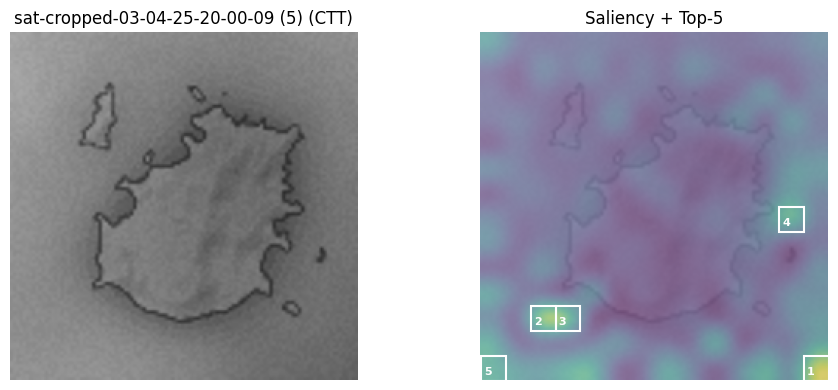

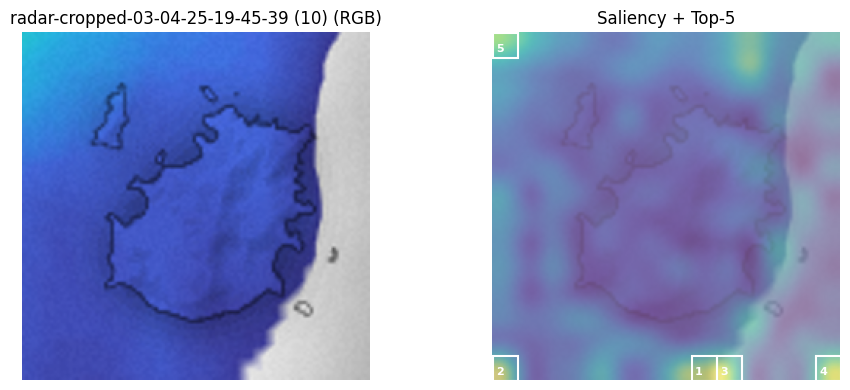

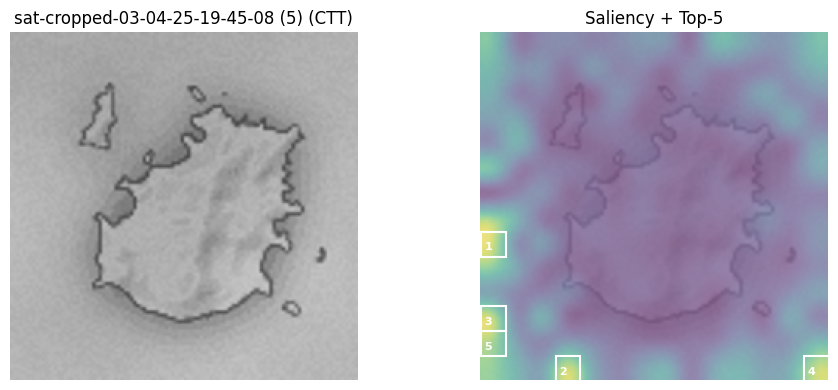

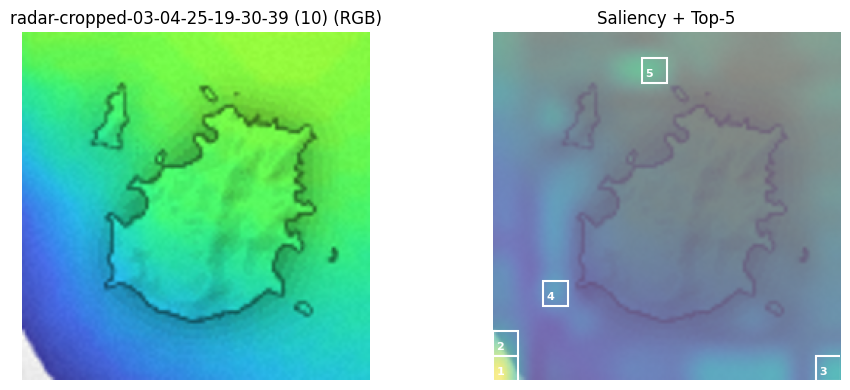

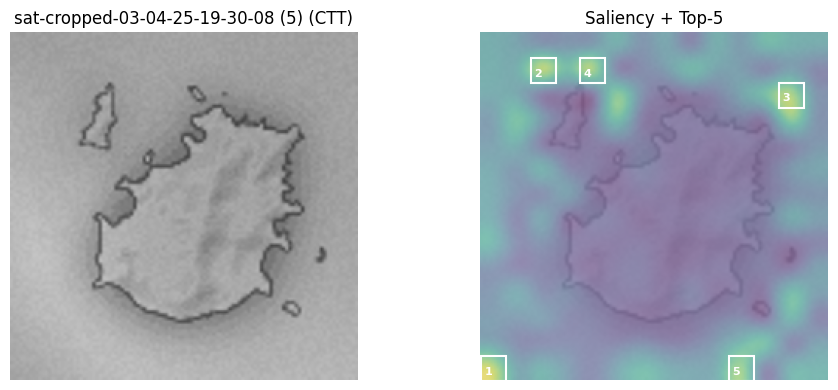

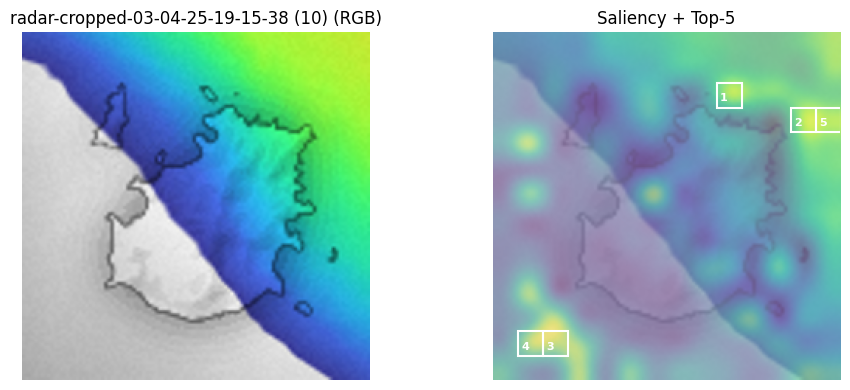

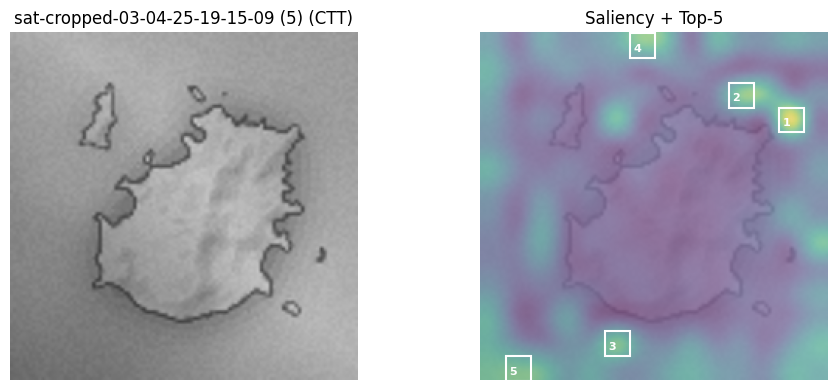

,file,modality,Gray%_w,R%,G%,B%,j1,s1,w1,r1,...,dhat4,j5,s5,w5,r5,c5,x5,y5,d5,dhat5
0,radar-cropped-03-04-25-20-00-40 (11).png,RGB,72.721596,32.250496,32.322517,35.426987,1,0.022872,0.219289,1,...,0.860114,3,0.018711,0.179398,1,3,40.0,8.0,126.491,0.798596
1,sat-cropped-03-04-25-20-00-09 (5).png,CTT,48.209606,33.333336,33.333336,33.333336,196,0.019994,0.250929,14,...,0.557875,183,0.013260,0.166413,14,1,8.0,216.0,147.078,0.928571
2,radar-cropped-03-04-25-19-45-39 (10).png,RGB,54.829643,25.010279,31.963938,43.025780,191,0.017965,0.203086,14,...,0.928571,1,0.017286,0.195409,1,1,8.0,8.0,147.078,0.928571
3,sat-cropped-03-04-25-19-45-08 (5).png,CTT,70.806427,33.333336,33.333336,33.333336,113,0.021067,0.210552,9,...,0.928571,169,0.018369,0.183587,13,1,8.0,200.0,136.235,0.860114
4,radar-cropped-03-04-25-19-30-39 (10).png,RGB,66.057800,25.219778,36.354694,38.425529,183,0.051780,0.339040,14,...,0.575876,21,0.020786,0.136097,2,7,104.0,24.0,88.363,0.557875
5,sat-cropped-03-04-25-19-30-08 (5).png,CTT,64.914085,33.333332,33.333332,33.333332,183,0.018897,0.214781,14,...,0.610286,193,0.016170,0.183793,14,11,168.0,216.0,118.119,0.745736
6,radar-cropped-03-04-25-19-15-38 (10).png,RGB,71.938087,29.534462,45.395699,25.069836,38,0.014330,0.204591,3,...,0.785714,56,0.013697,0.195555,4,14,216.0,56.0,118.119,0.745736
7,sat-cropped-03-04-25-19-15-09 (5).png,CTT,56.474731,33.333336,33.333336,33.333336,55,0.020896,0.258521,4,...,0.658539,184,0.014566,0.180205,14,2,24.0,216.0,136.235,0.860114


Saved: vit_metrics_sat_rad.csv


In [ ]:

!pip install -q transformers timm pandas

import os
import numpy as np
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from google.colab import files
from transformers import ViTFeatureExtractor, ViTForImageClassification


MODEL_NAME = "google/vit-base-patch16-224"
fe  = ViTFeatureExtractor.from_pretrained(MODEL_NAME)
vit = ViTForImageClassification.from_pretrained(MODEL_NAME, output_attentions=True).eval()

P = 16
H_img = W_img = 224
N   = (H_img * W_img) // (P**2)
H_p = H_img // P
W_p = W_img // P
x_c, y_c = W_img/2, H_img/2
d_max = 0.5 * np.sqrt(H_img**2 + W_img**2)


CROP_X, CROP_Y, CROP_W, CROP_H = 70, 120, 110, 110


SAVE_TOP5_PATCHES = False
os.makedirs("top5_patches", exist_ok=True)


def rec601_luma(rgb_uint8):
    """g(u,v) = 0.299R + 0.587G + 0.114B (0..255)"""
    R = rgb_uint8[...,0].astype(np.float32)
    G = rgb_uint8[...,1].astype(np.float32)
    B = rgb_uint8[...,2].astype(np.float32)
    return 0.299*R + 0.587*G + 0.114*B

def rc_from_index(j0):
    """j0 (0..N-1) -> (r_j, c_j) 1-indexed"""
    r0 = j0 // W_p
    c0 = j0 %  W_p
    return (r0+1, c0+1)

def center_xy(r, c):
    """x_j=(c-1/2)P, y_j=(r-1/2)P (center of patch)"""
    return ( (c-0.5)*P, (r-0.5)*P )

def run_vit_and_metrics_single(img_np_aux, modality, fname_stub):
    """
    modality: "RGB" or "CTT"
    img_np_aux:
      - RGB: (H,W,3) uint8
      - CTT: (H,W) float32 or uint8 (จะ replicate เพื่อเข้า ViT)
    returns: dict summary + per_patch list + heatmap for viz
    """

    if modality == "RGB":
        rgb_for_model = img_np_aux.astype(np.uint8)
    else:
        gray = img_np_aux.astype(np.float32)
        three = np.stack([gray]*3, axis=-1)
        if three.max() <= 1.0: three = (three*255.0)
        rgb_for_model = three.astype(np.uint8)


    inputs = fe(images=Image.fromarray(rgb_for_model), return_tensors="pt")
    with torch.no_grad():
        out = vit(**inputs)

    att_last = out.attentions[-1][0]

    s = att_last[:, 0, 1:].mean(dim=0).cpu().numpy()


    top5_idx = np.argsort(s)[-5:][::-1]
    s_top5   = s[top5_idx]
    w_top5   = s_top5 / (s_top5.sum() + 1e-12)


    heat14  = s.reshape(H_p, W_p)
    heat224 = cv2.resize(heat14, (W_img, H_img), interpolation=cv2.INTER_CUBIC)


    per_patch = []
    S_R = S_G = S_B = 0.0
    gray_weighted_sum = 0.0

    for rank, (j_idx, wj) in enumerate(zip(top5_idx, w_top5), start=1):
        rj, cj = rc_from_index(int(j_idx))
        xj, yj = center_xy(rj, cj)
        dj = float(np.sqrt((xj-x_c)**2 + (yj-y_c)**2))
        dh = dj / d_max

        y0 = (rj-1)*P
        x0 = (cj-1)*P

        patch_rgb = rgb_for_model[y0:y0+P, x0:x0+P, :].astype(np.float32)

        if modality == "RGB":
            g_norm = rec601_luma(patch_rgb) / 255.0
        else:

            g_norm = patch_rgb[...,0] / 255.0
        gray_weighted_sum += wj * g_norm.mean()

        S_R += wj * patch_rgb[...,0].sum()
        S_G += wj * patch_rgb[...,1].sum()
        S_B += wj * patch_rgb[...,2].sum()

        if SAVE_TOP5_PATCHES:
            if modality == "RGB":
                outname = f"top5_patches/{fname_stub}_RGB_rank{rank}_r{rj}_c{cj}.png"
                cv2.imwrite(outname, cv2.cvtColor(patch_rgb.astype(np.uint8), cv2.COLOR_RGB2BGR))
            else:
                outname = f"top5_patches/{fname_stub}_CTT_rank{rank}_r{rj}_c{cj}.png"
                cv2.imwrite(outname, patch_rgb[...,0].astype(np.uint8))

        per_patch.append({
            "rank": rank,
            "j": int(j_idx) + 1,   # 1..N
            "s_j": float(s_top5[rank-1]),
            "w_j": float(wj),
            "r_j": int(rj),
            "c_j": int(cj),
            "x_j": float(xj),
            "y_j": float(yj),
            "d_j": float(dj),
            "d_hat": float(dh),
        })

    Gray_percent_w = 100.0 * gray_weighted_sum

    denom = S_R + S_G + S_B + 1e-12
    R_percent = 100.0 * (S_R/denom)
    G_percent = 100.0 * (S_G/denom)
    B_percent = 100.0 * (S_B/denom)

    summary = {
        "modality": modality,
        "Gray%_w": float(np.round(Gray_percent_w, 6)),
        "R%": float(np.round(R_percent,6)),
        "G%": float(np.round(G_percent,6)),
        "B%": float(np.round(B_percent,6)),
        "heat224": heat224,
        "per_patch": per_patch
    }
    return summary

uploaded = files.upload()
if not uploaded:
    raise ValueError("No files uploaded!")

rows = []

for fname in uploaded.keys():
    base = os.path.splitext(os.path.basename(fname))[0]
    name_lc = fname.lower()

    img = Image.open(fname)
    cropped = img.crop((CROP_X, CROP_Y, CROP_X+CROP_W, CROP_Y+CROP_H)).resize((W_img, H_img))

    if "sat" in name_lc:
        crop_gray = cropped.convert("L")
        np_gray   = np.array(crop_gray).astype(np.float32) / 255.0
        summary   = run_vit_and_metrics_single(np_gray, "CTT", base)

    elif "rad" in name_lc:
        crop_rgb = cropped.convert("RGB")
        np_rgb   = np.array(crop_rgb)
        summary  = run_vit_and_metrics_single(np_rgb, "RGB", base)

    else:
        print(f"[WARN] '{fname}' ไม่พบ 'sat' หรือ 'rad' ในชื่อไฟล์ → ใช้ RGB เป็นค่าเริ่มต้น")
        crop_rgb = cropped.convert("RGB")
        np_rgb   = np.array(crop_rgb)
        summary  = run_vit_and_metrics_single(np_rgb, "RGB", base)


    row = {
        "file": fname, "modality": summary["modality"],
        "Gray%_w": summary["Gray%_w"], "R%": summary["R%"], "G%": summary["G%"], "B%": summary["B%"]
    }
    for item in summary["per_patch"]:
        k = item["rank"]
        row[f"j{k}"]=item["j"]; row[f"s{k}"]=np.round(item["s_j"],6)
        row[f"w{k}"]=np.round(item["w_j"],6)
        row[f"r{k}"]=item["r_j"]; row[f"c{k}"]=item["c_j"]
        row[f"x{k}"]=np.round(item["x_j"],3); row[f"y{k}"]=np.round(item["y_j"],3)
        row[f"d{k}"]=np.round(item["d_j"],3); row[f"dhat{k}"]=np.round(item["d_hat"],6)
    rows.append(row)

    # Visualization
    heat = summary["heat224"]
    if summary["modality"] == "RGB":
        img_show = np.array(cropped.convert("RGB"))
    else:
        g = (np.array(cropped.convert("L")).astype(np.float32) / 255.0)
        img_show = (np.stack([g]*3, axis=-1) * 255.0).astype(np.uint8)

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(img_show.astype(np.uint8)); ax[0].set_title(f"{base} ({summary['modality']})"); ax[0].axis("off")
    ax[1].imshow(img_show.astype(np.uint8), alpha=0.5); ax[1].imshow(heat, alpha=0.5)
    for it in summary["per_patch"]:
        rj, cj = it["r_j"], it["c_j"]
        x0, y0 = (cj-1)*P, (rj-1)*P
        rect = patches.Rectangle((x0,y0), P,P, linewidth=1.5, edgecolor='w', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(x0+2, y0+12, f"{it['rank']}", color='w', fontsize=8, weight='bold')
    ax[1].set_title("Saliency + Top-5"); ax[1].axis("off")
    plt.tight_layout(); plt.show()

df = pd.DataFrame(rows)
display(df)
df.to_csv("vit_metrics_sat_rad.csv", index=False)
print("Saved: vit_metrics_sat_rad.csv")
